In [ ]:
!wget https://download1478.mediafire.com/msja9k8ufwigK-yS3a28caxLzvFHlLA6XNMXG5bbGzTFF1ZVPbZUXRjqAsoeT4x8BTExJS6ivbNr1fpBF1Un4IgOwKPD9x2OfOHIacZos7tBqSwh_H3nXrjySP8colTlW-VpwUombaRl5Xe9bqAgXjqaqjGDO1qz8MO2a2PjslwV/o8cu4u222zgagwf/ASL_Alph_Redim.zip

--2024-10-13 14:45:47--  https://download1478.mediafire.com/msja9k8ufwigK-yS3a28caxLzvFHlLA6XNMXG5bbGzTFF1ZVPbZUXRjqAsoeT4x8BTExJS6ivbNr1fpBF1Un4IgOwKPD9x2OfOHIacZos7tBqSwh_H3nXrjySP8colTlW-VpwUombaRl5Xe9bqAgXjqaqjGDO1qz8MO2a2PjslwV/o8cu4u222zgagwf/ASL_Alph_Redim.zip
Resolving download1478.mediafire.com (download1478.mediafire.com)... 205.196.123.166
Connecting to download1478.mediafire.com (download1478.mediafire.com)|205.196.123.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216399571 (1.1G) [application/zip]
Saving to: ‘ASL_Alph_Redim.zip’

ASL_Alph_Redim.zip  100%[===================>]   1.13G  6.86MB/s    in 1m 58s  

2024-10-13 14:47:46 (9.82 MB/s) - ‘ASL_Alph_Redim.zip’ saved [1216399571/1216399571]



In [ ]:
!unzip /content/ASL_Alph_Redim.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ASL_Alph_Redim/Z/Z (3168).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3169).jpg  
  inflating: ASL_Alph_Redim/Z/Z (317).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3170).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3171).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3172).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3173).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3174).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3175).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3176).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3177).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3178).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3179).jpg  
  inflating: ASL_Alph_Redim/Z/Z (318).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3180).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3181).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3182).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3183).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3184).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3185).jpg  
  inflating: ASL_Alph_Redim/Z/Z (3186).jp

In [6]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [ ]:
# Ruta al directorio del dataset
data_dir = '/content/ASL_Alph_Redim'

# Parámetros
img_height, img_width = 200, 200
batch_size = 512

# Data augmentation y preprocesamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.1, 0.9),
    fill_mode='nearest',
    validation_split=0.2  # Dividir 80% para entrenamiento y 20% para validación
)

# Crear generadores
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',   # Usar el 80% de los datos para entrenamiento
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Usar el 20% de los datos para validación
    shuffle=False
)

print(f"Cantidad en set de entrenamiento: {train_generator.samples}")
print(f"Cantidad en set de validación: {validation_generator.samples}")

Found 178472 images belonging to 29 classes.
Found 44602 images belonging to 29 classes.
Cantidad en set de entrenamiento: 178472
Cantidad en set de validación: 44602


Guardamos el desbalance de clases

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Creamos el modelo base

In [ ]:
def _conv_model():
  model = models.Sequential()
  # Primera capa convolucional
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
  model.add(layers.MaxPooling2D())

  # Segunda capa convolucional
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  # Tercera capa convolucional
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  # Cuarta capa convolucional
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  # Aplanamiento y capas densas
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))  # Previene sobreajuste
  model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

  return model

In [ ]:
model = _conv_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weights
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


349/349 ━━━━━━━━━━━━━━━━━━━━ 2286s 6s/step - accuracy: 0.0566 - loss: 3.2811 - val_accuracy: 0.1966 - val_loss: 2.7595
Epoch 2/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 2230s 6s/step - accuracy: 0.2150 - loss: 2.5745 - val_accuracy: 0.3406 - val_loss: 2.2691
Epoch 3/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 2224s 6s/step - accuracy: 0.3431 - loss: 2.0735 - val_accuracy: 0.4306 - val_loss: 2.0232
Epoch 4/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 2212s 6s/step - accuracy: 0.4216 - loss: 1.7844 - val_accuracy: 0.4821 - val_loss: 1.9354
Epoch 5/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 2193s 6s/step - accuracy: 0.4711 - loss: 1.6166 - val_accuracy: 0.4983 - val_loss: 1.8318
Epoch 6/15
183/349 ━━━━━━━━━━━━━━━━━━━━ 13:52 5s/step - accuracy: 0.5062 - loss: 1.4998

In [8]:
clases = {'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'Nothing': 14,
 'O': 15,
 'P': 16,
 'Q': 17,
 'R': 18,
 'S': 19,
 'Space': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27}

In [4]:
from tensorflow.keras.models import load_model

# Cargamos el modelo
model = load_model('arq_modelo_10.h5')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 67712)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      34,669,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │          14,877 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,777,183 (132.66 MB)

 Trainable params: 34,777,181 (132.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


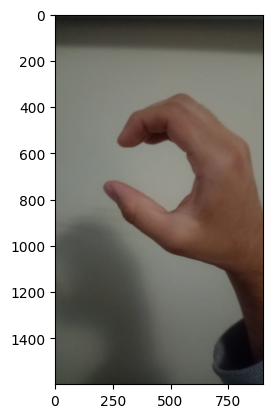

La seña predicha es: O


In [28]:
from tensorflow.keras.preprocessing import image

def predict_sign(img_path, model):
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Invertir el diccionario de class_indices
    class_indices = {v: k for k, v in clases.items()}

    # Obtener la clase predicha
    predicted_class_name = class_indices[predicted_class[0]]
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    return predicted_class_name

# Ejemplo de uso
# Asegúrate de que la ruta a tu imagen sea correcta
sign = predict_sign('/content/prueba_data/c_2.jpg', model)
print("La seña predicha es:", sign)